# Advanced Lane Finding

## Importing required packages

In [1]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
% matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Camera Calibration
[create an anchor](#anchors-in-markdown)

0. importing calibration images (chessboard images)
0. initiation of object and image points list
0. converting to grayscale
0. finding corners as imagepoints and appending object points (constant)
0. saving the resulting corner detection in an output folder over the original images
0. calibrate the opencv camera model using the object and image points
0. In order to test the model, we use the undistort function on a test image, not seen by calibration function, with the model gained above

In [ ]:
# importing image address
chsbrd_cal_img_path = 'camera_cal'
chsbrd_output_img_path = 'camera_cal/out_put_corners'

cal_imgs = glob.glob(chsbrd_cal_img_path + '/calibration*.jpg')

# initiating object and image points list
obj_points = []
img_points = []
test_imgs_path = []

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

objp=np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


number_of_images_with_well_found_corners = 0
for img_path in cal_imgs:
    # import image
    cal_img = mpimg.imread(img_path)
    # convert to grayscale
    cal_img_gray = cv2.cvtColor(cal_img,cv2.COLOR_RGB2GRAY)
    """
    if images are not good enough or you made them from your monitor screen you will habe a lot of noise
    in the images (because of nature of monitor refresh you will have some noises in white areas) you 
    may want to filter images from and use it (without prining the chess board). In this case use the
    following filter and uncomment it:
    """
#     gray_editted = cv2.blur(cal_img_gray,(10,10))
#     gray_editted = (gray_editted>110)*255
#     cal_img_gray = 255-np.uint8(gray_editted)    
    
    # find corners
    ret, corners = cv2.findChessboardCorners(cal_img_gray,(nx,ny))
    
    # finding the name of the imported file and save the image with the same name in the other directory
    img_file_name = img_path.split('/')[-1].split('.')[0]
    if ret is True:
        number_of_images_with_well_found_corners += 1
        img_points.append(corners)
        obj_points.append(objp)
        # draw the corners on images and save it
        output_img = cv2.drawChessboardCorners(cal_img,(nx,ny),corners,ret)
        mpimg.imsave(chsbrd_output_img_path+'/'+img_file_name , output_img)
    else:
        print ('Corners of image {} are not found.'.format(img_file_name))
        test_imgs_path.append(img_path)

print('OpenCV found the corners of {} images from {} images'.
      format(number_of_images_with_well_found_corners,len(cal_imgs)))

Corners of some of the images are not found because all corners were not inside the image or they were very close to the border of image. We can use these images to test the model to undistort and transform the chessboard for our model test algoritm.

In [ ]:
# Calibrating camera using the obtained corners:
print('Calibrating the model')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, cal_img_gray.shape[::-1], None, None)
camera_to_save={"camera_matrix":mtx,"camera_distortion":dist}
pickle.dump( camera_to_save, open( "camera_model_param.p", "wb" ) )
print('Calibration is Done and camera Matrix & Distortion are saved')
print('Camera Matrix:', ' \n',mtx)
print('Distortion Parameters:', ' \n',dist)


### Test the Calibration
0. demonstration of one of the images with found courners
0. undistorting and transforing the test images

In [ ]:
demo_img = mpimg.imread(chsbrd_output_img_path+'/calibration12')
plt.figure(figsize=(15,10))
plt.imshow(demo_img)
plt.title('Found Corners',fontsize=25)
plt.show()

In [ ]:
# undistoriting and transforming

def corners_unwarp(img_path, nx, ny,offsetx,offsety, mtx, dist):
    cal_img = mpimg.imread(img_path)
    heigth = cal_img.shape[0]
    width = cal_img.shape[1]
    # undistort image:
    img_undistorted = cv2.undistort(cal_img, mtx, dist, None, mtx)
    # convert to grayscale
    cal_img_gray = cv2.cvtColor(cal_img,cv2.COLOR_RGB2GRAY)
    # by changing these numbers, the opencv will find some on test images
    ret, corners = cv2.findChessboardCorners(cal_img_gray,(nx,ny),None)
    if ret is True:
        output_img_with_corners = cv2.drawChessboardCorners(cal_img,(nx,ny),corners,ret)
        src = np.float32([
            np.squeeze(corners[0]),
            np.squeeze(corners[nx-1]),
            np.squeeze(corners[nx*(ny-1)]),
            np.squeeze(corners[nx*ny-1])
            ])
        dst = np.float32([
            [offsetx,offsety],
            [width-offsetx,offsety],
            [offsetx,heigth-offsety],
            [width-offsetx,heigth-offsety]
        ])
        M = cv2.getPerspectiveTransform(src,dst)
        img_size = (width,heigth)
        warped = cv2.warpPerspective(img_undistorted, M, img_size, flags=cv2.INTER_LINEAR)
        plt.figure(figsize=(17,8))
        plt.subplot(121)
        plt.imshow(output_img_with_corners)
        plt.subplot(122)
        plt.imshow(warped)
        plt.show()

for img_path in test_imgs_path:
    corners_unwarp(img_path, nx-2, ny-1,400,120, mtx, dist)

## Main pipline:
Now having the calibrated model of image, a pipeline should be design that is working for at least one frame and then later will be applied for a video. The pipeline should include:
0. Camera Calibration (which is done above)
0. Distortion correction on road image
0. Perspective Transform to get a bird-eye view of the road (simply top view of the road)
0. Color and Gradient thresholing to find a rough place of lanes
0. Fine tunning the previous methof using the sliding window and histogram
0. Find curvature equation

In [2]:
def get_camera_para ():
    """
    loads the camera model parameter and returns two arrays
    camera matrix and camera distortion parameters
    """
    camera_model = pickle.load( open( "camera_model_param.p", "rb" ) )
    return camera_model["camera_matrix"],camera_model["camera_distortion"]


def undistor_img(img, mtx, dist):
    img_undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return img_undistorted

(720, 1280, 3)


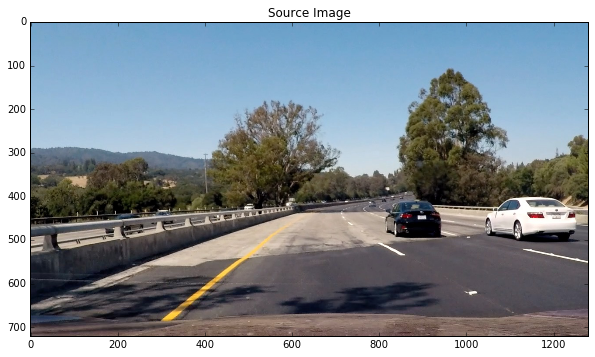

In [3]:
test_imgs_path_folder = 'test_images'
test_imgs_path = glob.glob(test_imgs_path_folder+'/*.jpg',)
difficult_imgs = glob.glob(test_imgs_path_folder+'/problem*.jpg',)
mtx,dist = get_camera_para()
test_img_idx = 5
test_img = mpimg.imread(test_imgs_path[test_img_idx])
print(test_img.shape)

plt.figure(figsize=(10,8))
plt.imshow(test_img)
plt.title('Source Image')
plt.show()

In [ ]:
# undistort image
img_undistorted = undistor_img(test_img,mtx,dist)
plt.figure(figsize=(10,8))
plt.imshow(img_undistorted)
plt.title('Undistorted Image')
plt.show()

In [4]:
# transformation
# src = np.float32([[213,705],[1074,692],[667,435],[614,435]])
# dst_small = np.float32([[213,705],[1074,692],[1076,0],[213,0]])
# src line equation for transformation
left_points_x = np.float32([213,614])
left_points_y = np.float32([705,435])

right_points_x = np.float32([1074,667])
right_points_y = np.float32([692,435])

left_line_trans = np.polyfit(left_points_y,left_points_x,1)
right_line_trans = np.polyfit(right_points_y,right_points_x,1)

src_size = (test_img.shape[1],test_img.shape[0])
dst_size = (int(test_img.shape[1]*1.2),int(test_img.shape[0]))

In [5]:
# transformation
def get_transform_matrices(left_line_trans,right_line_trans,src_size,dst_size):
    mid_x_src = src_size[0] / 2
    mid_x_dst = dst_size[0] / 2

    y2 = 705
    y1 = 450 # 460
    src = np.float32([[np.polyval(left_line_trans,y2),y2],
                      [np.polyval(right_line_trans,y2),y2],
                      [np.polyval(right_line_trans,y1),y1],
                      [np.polyval(left_line_trans,y1),y1]])

    dst=np.float32([[mid_x_dst - (mid_x_src - src[0,0]) , dst_size[1]-(src_size[1]-src[0,1])],
         [mid_x_dst - (mid_x_src - src[1,0]) , dst_size[1]-(src_size[1]-src[1,1])],
         [mid_x_dst - (mid_x_src - src[1,0]) , dst_size[1]-(src_size[1]-0)],
         [mid_x_dst - (mid_x_src - src[0,0]) , dst_size[1]-(src_size[1]-0)]])
    M = cv2.getPerspectiveTransform(src,dst)
    M_inv = cv2.getPerspectiveTransform(dst,src)
    return M,M_inv,src # src is required for drawing the polygon to transform

# warped = cv2.warpPerspective(img_undistorted, M, dst_size, flags=cv2.INTER_LINEAR)

def draw_transform_polygon(img,src_points):
    img_undistorted_with_polygon = img.copy()
    cv2.polylines(img_undistorted_with_polygon, np.int32([src]),True,[255,0,0],5)
    return img_undistorted_with_polygon

In [6]:
def thresholding (arr,thresh):
    """
    General thresholding
    """
    binary_out = np.zeros_like(arr)
    binary_out[(arr>=thresh[0])&(arr<=thresh[1])]=1
    return binary_out

def scaling(arr):
    arr_scaled = np.uint8(255.0*arr/np.max(arr))
    return arr_scaled

def abs_sobel_thresh(channel,sobel_kernel = 3, orient='x', thresh=(0,255)):
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient is 'x':
        sobel_img = cv2.Sobel(channel, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    else:
        sobel_img = cv2.Sobel(channel, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # Take the absolute value of the derivative or gradient
    sobel_abs = np.absolute(sobel_img)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel_scaled = scaling(sobel_abs)
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_img = thresholding(sobel_scaled,thresh)
    # 6) Return this mask as your binary_output image
    return binary_img,sobel_scaled

def mag_sobel_thresh(channel, sobel_kernel=3, thresh=(0, 255)):
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # Calculate the magnitude 
    abs_sobel = np.sqrt(np.power(sobelx,2)+np.power(sobely,2))
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = scaling(abs_sobel)
    # Create a binary mask where mag thresholds are met
    binary_img = thresholding(scaled_sobel,thresh)
    # Return this mask as your binary_output image
    return binary_img,scaled_sobel

def dir_sobel_thresh(channel, sobel_kernel=3, thresh=(-np.pi/2, np.pi/2)):
    #  Take the gradient in x and y separately
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(np.power(sobelx,2))
    abs_sobely = np.sqrt(np.power(sobely,2))
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    angle = np.arctan2(abs_sobely, abs_sobelx)
    angle = np.absolute(angle)
    angle = scaling(angle)
    # Create a binary mask where direction thresholds are met
    binary_output = thresholding(angle,thresh)
    # Return this mask as your binary_output image
    return binary_output,angle

def grad_thresholding (warped_image,
                       s_channel_thresh =(160,255) ,
                       sobel_x_thresh=(30,255),
                       sobel_mag_thresh=(30, 255),
                       dir_thresh=(0,150),
                       ksize = 3):
    
    hls_img = cv2.cvtColor(warped_image,cv2.COLOR_RGB2HLS)
    #l_channel = hls_img[:,:,1]
    s_channel = hls_img[:,:,2]
    channel = s_channel
    #channel test
    #channel=scaling(channel)
    channel=s_channel
    channel_bin = thresholding(channel,thresh=s_channel_thresh)
    #sobell test
    sobel_x_bin,sobel_x = abs_sobel_thresh(channel, sobel_kernel=ksize,orient='x',thresh=sobel_x_thresh)
    # sobel mag test
    sobel_mag_bin,sobel_mag = mag_sobel_thresh(channel, sobel_kernel=ksize,thresh=sobel_mag_thresh )
    # dir test
    sobel_dir_bin,sobel_dir = dir_sobel_thresh(channel, sobel_kernel=ksize,thresh=dir_thresh )
    # combine
    combined_image = np.uint8(np.logical_and(sobel_mag_bin,channel_bin))
    return channel_bin,sobel_x_bin, sobel_mag_bin, sobel_dir_bin, combined_image

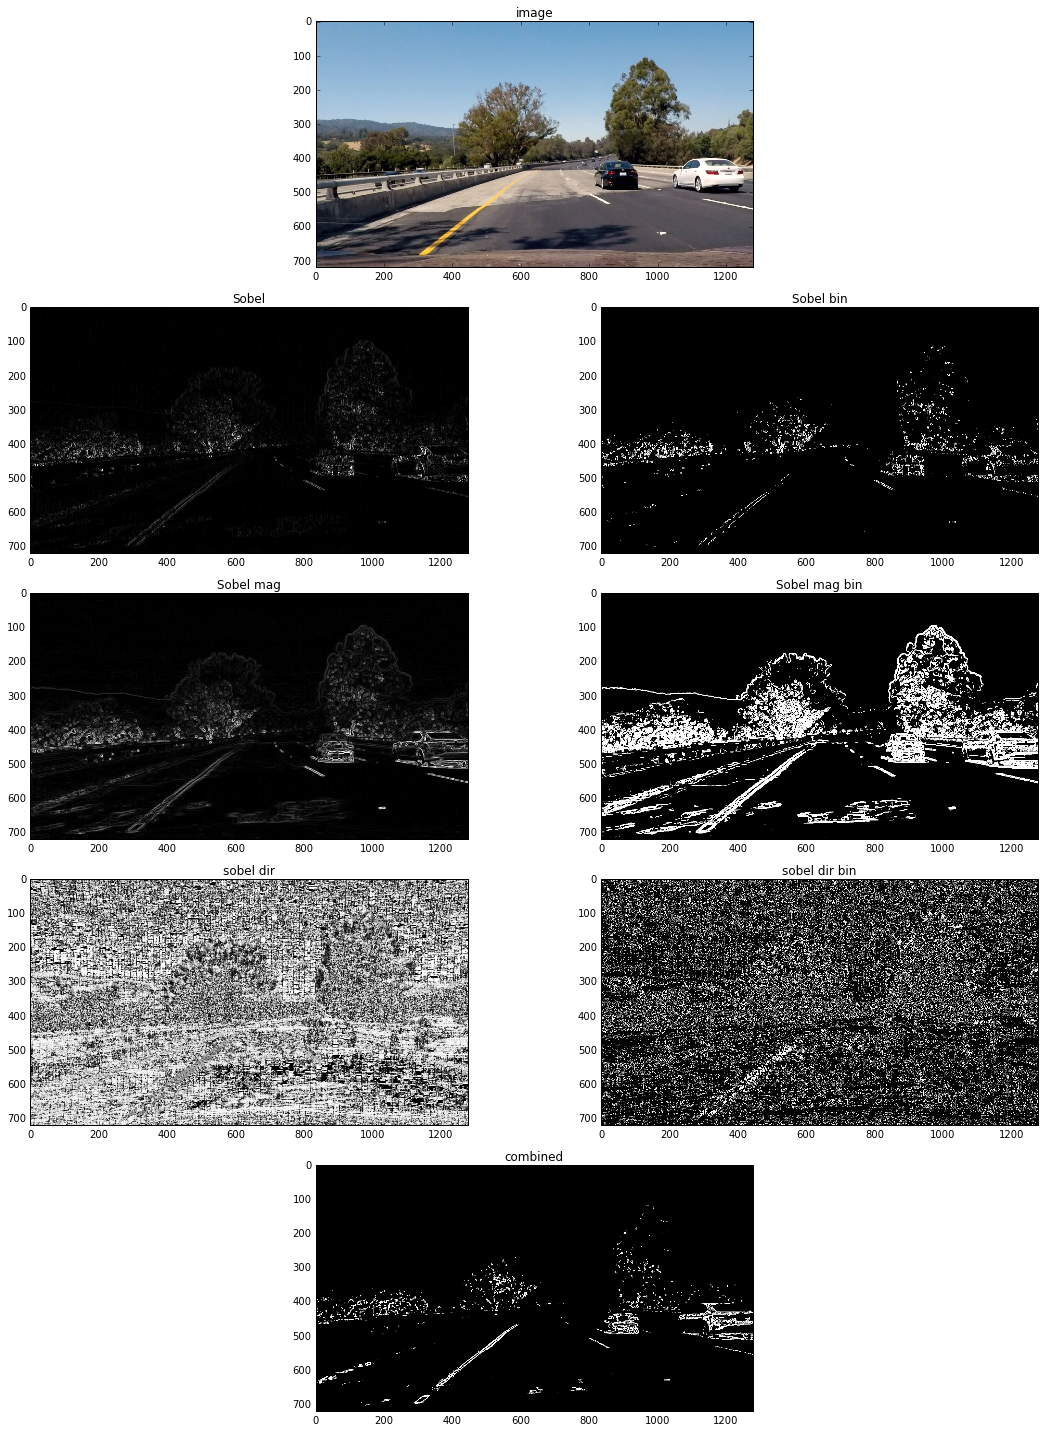

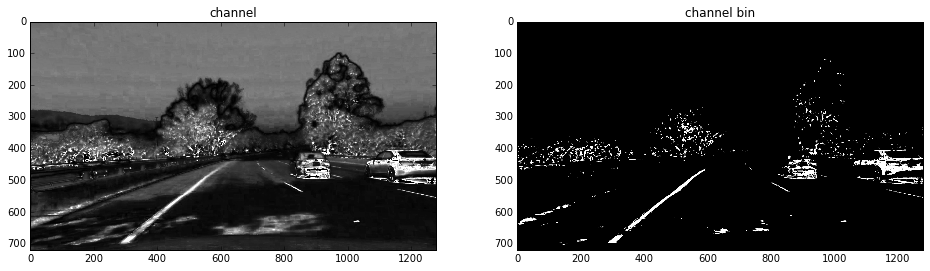

In [8]:
# conda install pyqt=4
# inline
# %matplotlib inline 
test_img = mpimg.imread(test_imgs_path[5])# test_imgs_path difficult_imgs
M, M_inv,_ = get_transform_matrices(left_line_trans,right_line_trans,src_size,dst_size)
#undistort
img_undistorted = undistor_img(test_img,mtx,dist)
warped = cv2.warpPerspective(img_undistorted, M, dst_size, flags=cv2.INTER_NEAREST)#INTER_LINEAR
# exctract S channel
hls_img = cv2.cvtColor(img_undistorted,cv2.COLOR_RGB2HLS)
l_channel = hls_img[:,:,1]
s_channel = hls_img[:,:,2]#2
channel = s_channel
# channel = scaling(s_channel)
#s_channel test
channel_bin = thresholding(channel,thresh=(150,255))
# print(np.max(channel))
#sobell test
sobel_x_bin,sobel_x = abs_sobel_thresh(channel, sobel_kernel=3,orient='x',thresh=(50,255))
# print(np.min(sobel_x),np.max(sobel_x))
# sobel mag test
sobel_mag_bin,sobel_mag = mag_sobel_thresh(channel, sobel_kernel=5,thresh=(20, 255) )
# dir test
sobel_dir_bin,sobel_dir = dir_sobel_thresh(channel, sobel_kernel=5,thresh=(80,150) )
# combine
combined_image = np.uint8(np.logical_and(channel_bin,sobel_mag_bin))

plt.figure(figsize=(16,20))
plt.subplot(511)
plt.imshow(test_img)
plt.title('image')
plt.subplot(523)
plt.imshow(sobel_x,cmap='gray')
plt.title('Sobel')
plt.subplot(524)
plt.imshow(sobel_x_bin,cmap='gray')
plt.title('Sobel bin')
plt.subplot(525)
plt.imshow(sobel_mag,cmap='gray')
plt.title('Sobel mag')
plt.subplot(526)
plt.imshow(sobel_mag_bin,cmap='gray')
plt.title('Sobel mag bin')
plt.subplot(527)
plt.imshow(sobel_dir,cmap='gray')
plt.title('sobel dir')
plt.subplot(528)
plt.imshow(sobel_dir_bin,cmap='gray')
plt.title('sobel dir bin')
plt.subplot(515)
plt.imshow(combined_image,cmap='gray')
plt.title('combined')
plt.tight_layout()
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(channel,cmap='gray')
plt.title('channel')
plt.subplot(122)
plt.imshow(channel_bin,cmap='gray')
plt.title('channel bin')
plt.show()

In [9]:
def histogram_peak_detection(img):
    histo = np.sum(img[int(img.shape[0]*2/5):,:], axis=0)
    mid_point = int(histo.shape[0]/2)
    left_peak = np.argmax(histo[:mid_point])
    right_peak = np.argmax(histo[mid_point:]) + mid_point
    return histo,left_peak,right_peak

def mask2rgb(binary_warped):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    return out_img

def get_nonzero_idx(binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    return nonzerox,nonzeroy

def get_left_right_line_pxl_pos(nonzerox,nonzeroy,left_lane_inds,right_lane_inds):
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx,lefty,rightx,righty

def find_lane_from_histogram(binary_warped,leftx_base,rightx_base):
    # sliding windows
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Identify the x and y positions of all nonzero pixels in the image
    nonzerox,nonzeroy = get_nonzero_idx(binary_warped)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) &
                          (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) &
                          (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) &
                           (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx,lefty,rightx,righty=get_left_right_line_pxl_pos(nonzerox,nonzeroy,left_lane_inds,right_lane_inds)
    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        return False, 0,0,0
    
    lane_inds = (left_lane_inds,right_lane_inds)
    lane_fit = (left_fit,right_fit)
    return True,out_img,lane_inds,lane_fit

# Generate x and y values for plotting
def generate_x_y_for_ploting(binary_warped,lane_fit):
    left_fit = lane_fit[0]
    right_fit = lane_fit[1]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    lane_fits_pts = (left_fitx,right_fitx,ploty)
    return lane_fits_pts

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def find_lane_from_pre_frame(binary_warped,lane_fit,margin=100):
    left_fit =lane_fit[0]
    right_fit =lane_fit[1] 
    nonzerox,nonzeroy = get_nonzero_idx(binary_warped)
    margin = 100
    left_lane_inds = (
        (nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
        (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = (
        (nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
        (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    # Again, extract left and right line pixel positions
    leftx,lefty,rightx,righty=get_left_right_line_pxl_pos(nonzerox,nonzeroy,left_lane_inds,right_lane_inds)    
    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        return False, 0,0
    lane_inds = (left_lane_inds,right_lane_inds)
    lane_fit = (left_fit,right_fit)
    return True,lane_inds,lane_fit

# Create an image to draw on and an image to show the selection window
def visualize_selected_curvy_window(binary_warped, lane_inds,lane_fits_pts,margin=100):
    left_lane_inds = lane_inds[0]
    right_lane_inds = lane_inds[1]
    
    left_fitx = lane_fits_pts[0]
    right_fitx = lane_fits_pts[1]
    ploty = lane_fits_pts[2]
    
    out_img = mask2rgb(binary_warped)
    window_img = np.zeros_like(out_img)
    nonzerox,nonzeroy = get_nonzero_idx(binary_warped)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    try:
        result [ploty.astype(int),left_fitx.astype(int), :]=[255,255,0] #yellow
        result [ploty.astype(int),right_fitx.astype(int), :]=[255,255,0] #yellow
    except:
        pass
    return result

def visualise_only_curves(binary_warped,lane_fits_pts,margin=20):  
    left_fitx = lane_fits_pts[0]
    right_fitx = lane_fits_pts[1]
    ploty = lane_fits_pts[2]
    
    out_img = np.zeros((binary_warped.shape[0],binary_warped.shape[1],3),dtype=np.uint8)
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(out_img, np.int_([left_line_pts]), (255,0, 0))
    cv2.fillPoly(out_img, np.int_([right_line_pts]), (0,0, 255))
    return out_img

def stack_images(img1,img2,img3,img4):
    width = img1.shape[1]
    
    img4 = cv2.resize(img4,None,
                      fx=width/3/img4.shape[1],fy=width/3/img4.shape[1])
    img2 = cv2.resize(img2,(img4.shape[1],img4.shape[0]))
    img3 = cv2.resize(img3,(img4.shape[1],img4.shape[0]))
    down_image = np.concatenate((img2,img3),axis=1)
    down_image = np.concatenate((down_image,img4),axis=1)
    down_image = cv2.resize(down_image,None,
                            fx=width/down_image.shape[1],fy=width/down_image.shape[1])
    result = np.uint8(np.concatenate((img1,down_image),axis=0))
    return result

def find_road_curv(lane_fit,y):
    left = lane_fit[0]
    right = lane_fit[1]
    left_r = (1 + (2*left[0]+left[1])**2)**(3/2)/abs(2*left[0])
    right_r = (1 + (2*right[0]+right[1])**2)**(3/2)/abs(2*right[0])
    return (left_r+right_r)/2

def check_two_lines(lane_fit):
    left = lane_fit[0]
    right = lane_fit[1]
    y = 650
    return np.abs(np.polyval(left,y)-np.polyval(right,y))>400

In [13]:
M, M_inv,_ = get_transform_matrices(left_line_trans,right_line_trans,src_size,dst_size)

def find_lanes(img):
    global is_detected
    global lane_inds,lane_fit,lane_fits_pts
#     is_detected = False
    img_undistorted = undistor_img(img,mtx,dist)
    s_channel_bin, sobel_x, sobel_mag, sobel_dir, combined_image = grad_thresholding(
        img_undistorted,
        s_channel_thresh =(70,255),
        sobel_x_thresh=(30,255),
        sobel_mag_thresh=(15, 300),
        dir_thresh=(0,100),
        ksize=7)
    warped1 = cv2.warpPerspective(combined_image, M, dst_size, flags=cv2.INTER_LINEAR)#cv2.INTER_LINEAR INTER_NEAREST
    warped2 = cv2.warpPerspective(img, M, dst_size, flags=cv2.INTER_LINEAR)#cv2.INTER_LINEAR INTER_NEAREST
    s_channel_bin2, sobel_x2, sobel_mag2, sobel_dir2, combined_image2 = grad_thresholding(
        warped2,
        s_channel_thresh =(30,255),
        sobel_x_thresh=(30,255),
        sobel_mag_thresh=(20, 300),
        dir_thresh=(0,100),
        ksize=15)

    binary_warped = np.zeros_like(sobel_x2)
    heigth_brd = int(binary_warped.shape[0]/3)
    binary_warped[:heigth_brd,:] = warped1[:heigth_brd,:]
    binary_warped[heigth_brd:,:] = sobel_x2[heigth_brd:,:]
#     binary_warped [690:,:] = 0 # cut a few of the image
    if is_detected is False:
        hist,le,ri = histogram_peak_detection(binary_warped)
        is_detected,out_img,lane_inds,lane_fit = find_lane_from_histogram(binary_warped,le,ri)
    else:
        is_detected ,lane_inds,lane_fit = find_lane_from_pre_frame(binary_warped,lane_fit)
        if is_detected and check_two_lines(lane_fit) is True:
                out_img = visualize_selected_curvy_window(binary_warped,lane_inds,lane_fits_pts,margin=100) 
        else:
            hist,le,ri = histogram_peak_detection(binary_warped)
            is_detected,out_img,lane_inds,lane_fit = find_lane_from_histogram(binary_warped,le,ri)
    if is_detected is False:
        out_img = mask2rgb(binary_warped)
        result = stack_images(img,mask2rgb(warped1),mask2rgb(sobel_x2),out_img)
    else:
        lane_fits_pts = generate_x_y_for_ploting(binary_warped,lane_fit)
        only_curves=visualise_only_curves(binary_warped,lane_fits_pts,margin=20)
        only_curves = cv2.warpPerspective(only_curves, M_inv, src_size, flags=cv2.INTER_LINEAR)
        out_img2 = cv2.addWeighted(img, 0.8, only_curves, 1, 0)
        #result = stack_images(out_img2,mask2rgb(s_channel_bin),mask2rgb(sobel_mag),out_img)
        result = stack_images(out_img2,mask2rgb(warped1),mask2rgb(sobel_x2),out_img)
        radius = find_road_curv(lane_fit,img.shape[0]-100)
        text = 'The radius of curvature: {:.5} meters'.format(radius)
        cv2.putText(result,text,(20,50),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255) , 2 ,cv2.LINE_AA)
    return result

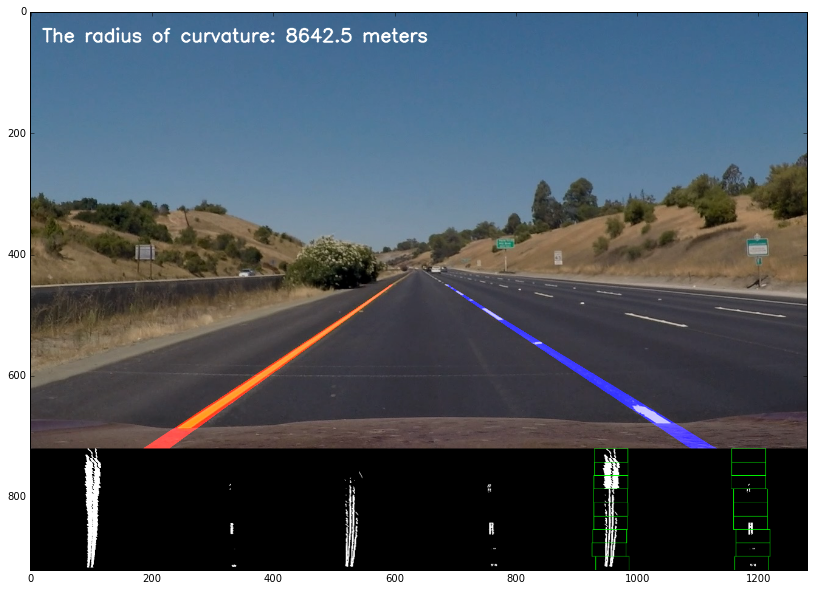

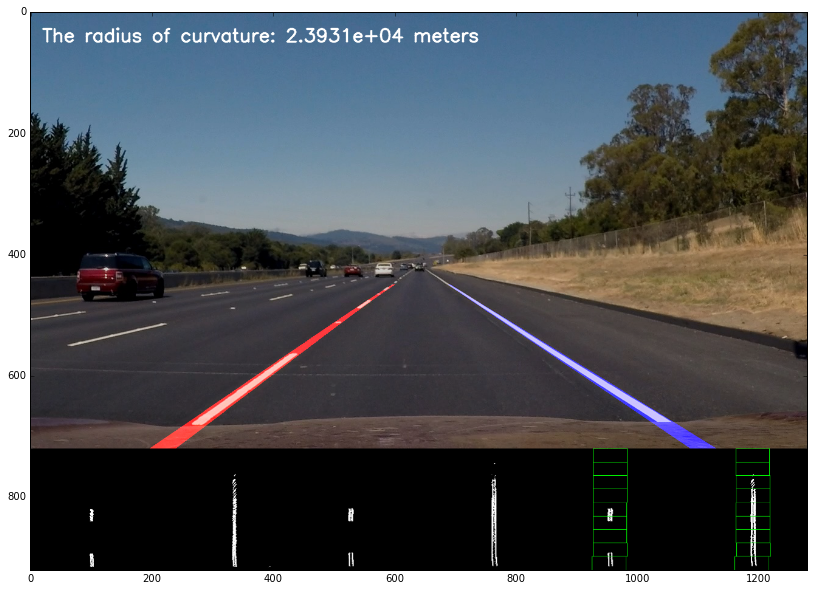

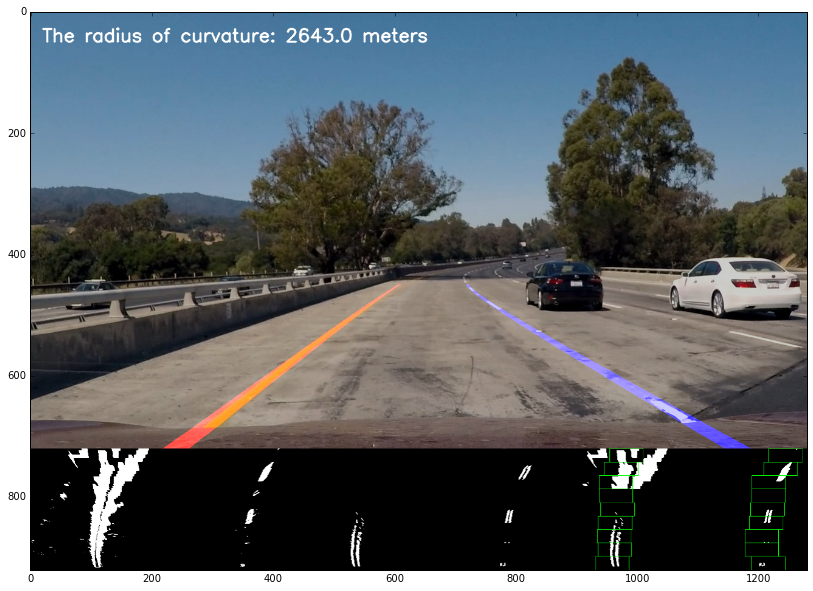

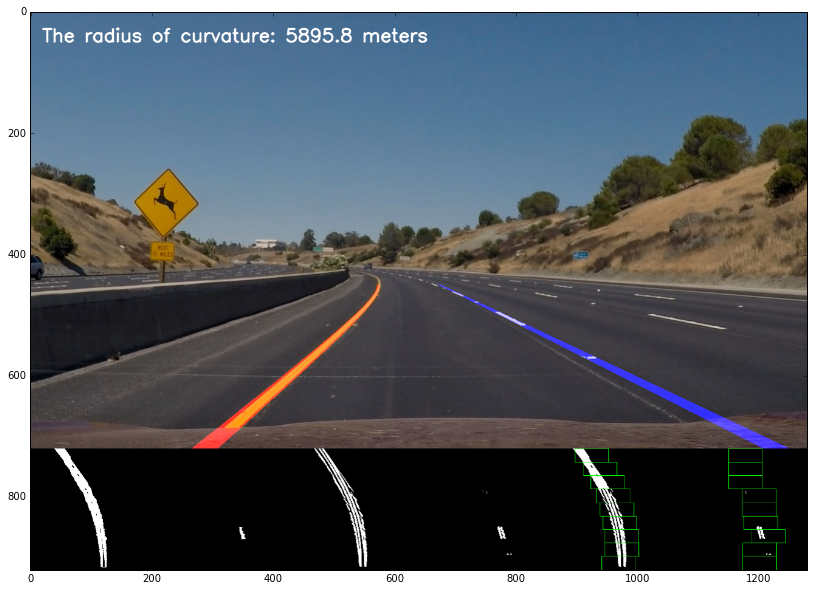

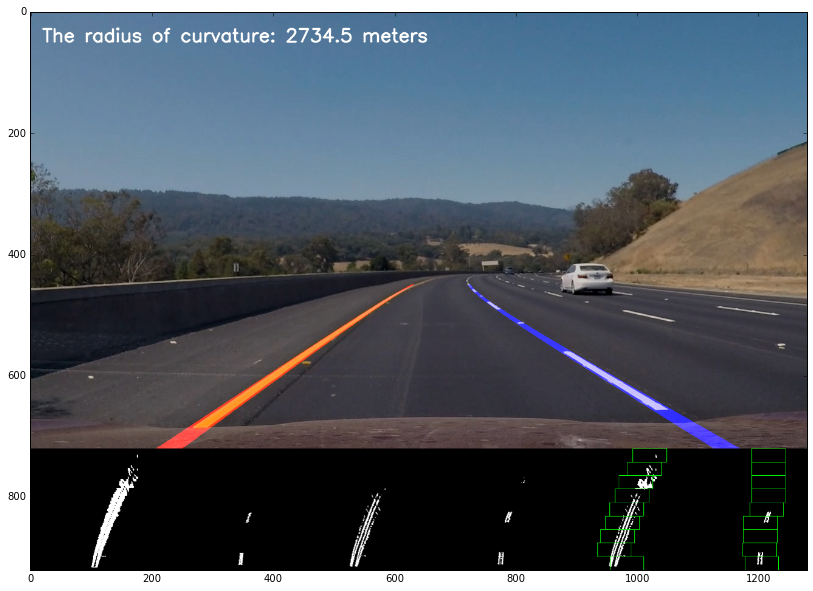

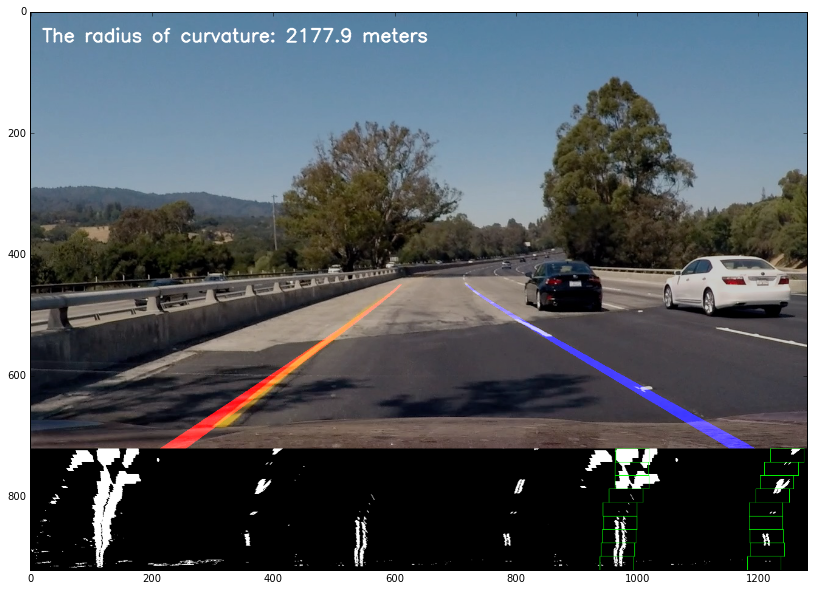

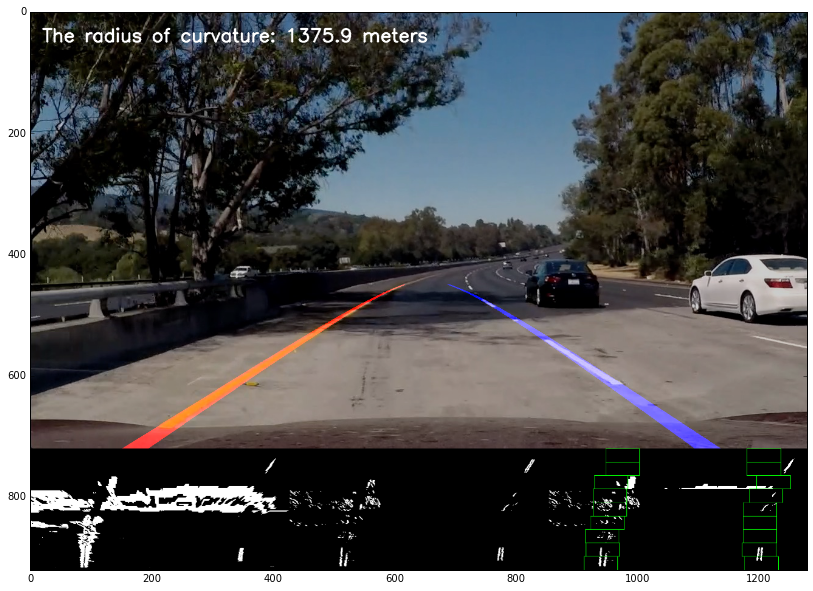

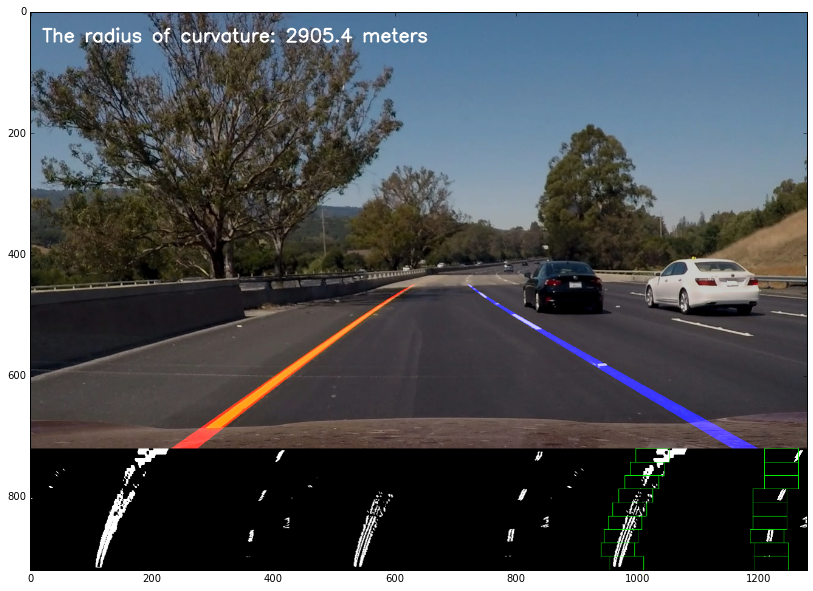

In [11]:
is_detected = False

for img_path in test_imgs_path: # test_imgs_path
    input_img = mpimg.imread(img_path)
    out = find_lanes(input_img)
    plt.figure(figsize=(16,10))
    plt.imshow(out)
    plt.show()

In [14]:
is_detected = False

output = 'out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(find_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4


100%|█████████▉| 1260/1261 [15:09<00:00,  1.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 

CPU times: user 20min 24s, sys: 3.89 s, total: 20min 28s
Wall time: 15min 10s
